In [1]:
import ast
import json
import os
import shutil
import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import torch
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from tensorflow import keras
from tqdm import tqdm
from src.generator import  Generator, GetModel

import tensorflow_addons as tfa


In [2]:
df = pd.read_csv("/app/_data/train.csv")

In [3]:
list_wrong = df[(df['class']!='negative')&(df['label']=='none 1 0 0 1 1')]['id_image'].tolist()
df = df.query('id_image not in @list_wrong').reset_index(drop=True)

In [4]:
with open("/app/_data/base_config.json", "r") as f:
    base_config = json.load(f)
base_config['EFFB7']["BATCH_SIZE"]=4
base_config

{'EFFB7': {'IMG_SIZE': 600,
  'BATCH_SIZE': 4,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b7_noisy-student_notop.h5'},
 'CLASS': {'negative': 0, 'typical': 1, 'indeterminate': 2, 'atypical': 3},
 'EFFB4': {'IMG_SIZE': 380,
  'BATCH_SIZE': 50,
  'SEED': 42,
  'WEIGHTS': '/app/_data/efficientnet-b4_noisy-student_notop.h5'}}

In [5]:
labels = pd.read_csv('/app/_data/additional_dataset/labels_full.csv')

In [6]:
labels = labels.query('Target==0').reset_index(drop=True)

In [7]:
labels['image'] = labels['patientId']+'.dcm'
labels['class'] = 'negative'

In [8]:
labels = labels[['image', 'class', 'modality', 'PatientSex', 'BodyPartExamined']]

In [9]:
df = pd.concat([df[['image', 'class', 'modality', 'PatientSex', 'BodyPartExamined']], labels.sample(2000)], ignore_index=True, axis=0).sample(frac=1, random_state=base_config['EFFB7']['SEED'])

In [10]:
df

,image,class,modality,PatientSex,BodyPartExamined
6074,b6aa50f1-f06f-4770-8223-1f357d0ec5a4.dcm,negative,CR,M,CHEST
5958,fd46997f5517.dcm,typical,DX,M,CHEST
3032,7d70c13f0e0b.dcm,indeterminate,CR,M,CHEST
6446,b461f0a1-e81c-467e-81f0-1af5a42ef9cb.dcm,negative,CR,M,CHEST
318,0b9ba021bb79.dcm,typical,DX,F,CHEST
...,...,...,...,...,...
5226,db5195cb50c4.dcm,negative,CR,F,CHEST
5390,e2834bb80a4f.dcm,typical,DX,M,CHEST
860,228083cd85ef.dcm,typical,CR,M,CHEST
7603,73028cb3-d09d-4d81-9640-88ef1571a4f1.dcm,negative,CR,F,CHEST


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
train_ids = []
val_ids = []
for train_index, valid_index in skf.split(df, df["class"]):
    train_ids.append(train_index)
    val_ids.append(valid_index)

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# shutil.rmtree('/app//_data/train_jpg_600/')

In [14]:
gen_train = Generator(
    df=df.loc[train_ids[4]],
    batch_size=base_config['EFFB7']["BATCH_SIZE"],
    seed=base_config['EFFB7']["SEED"],
    img_size=base_config['EFFB7']["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle =True,
    augment = True,
    n_inputs=2,
)
gen_valid = Generator(
    df=df.loc[val_ids[4]],
    batch_size=base_config['EFFB7']["BATCH_SIZE"],
    seed=base_config['EFFB7']["SEED"],
    img_size=base_config['EFFB7']["IMG_SIZE"],
    prepared_img_path="/app/_data/train_jpg_600/",
    shuffle =False,
    augment = False,
    n_inputs=2,
)

In [15]:
train_sample = gen_train.__getitem__(10)

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


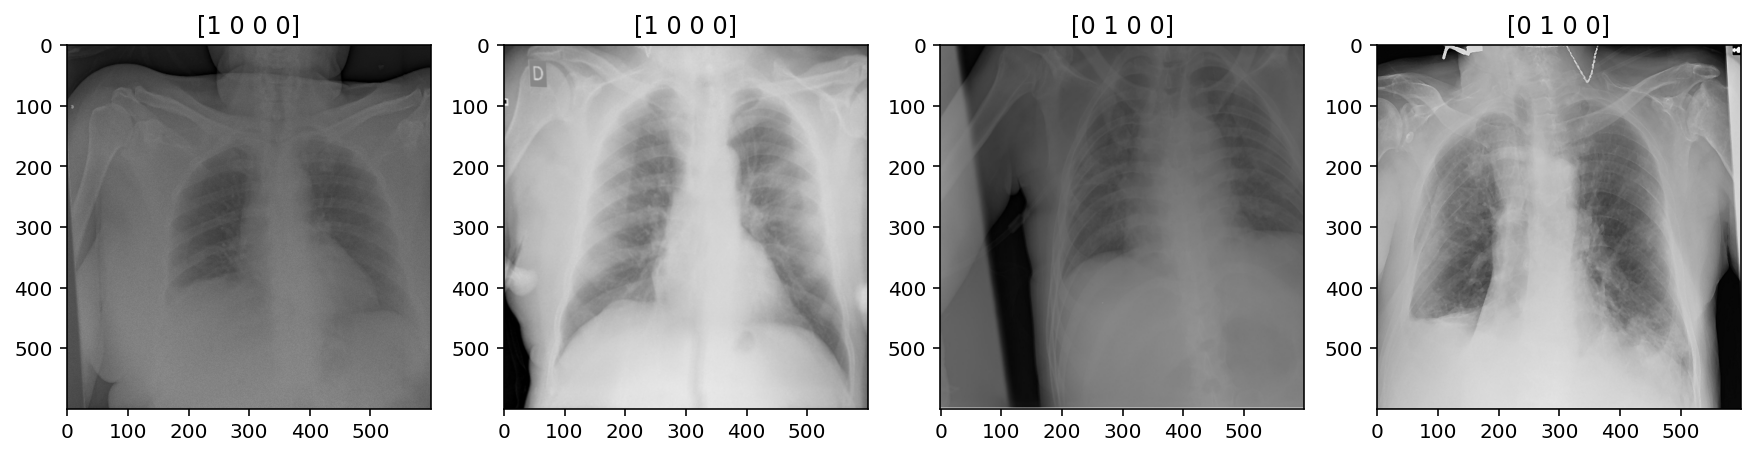

In [16]:
plt.figure(figsize = (15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(train_sample[1][i])
    plt.imshow(train_sample[0]['img'][i])

In [17]:
model = GetModel(model_name='EFFB7',n_inputs=2, lr=0.0007, activation_func='sigmoid', weights='imagenet').get_model()
policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [18]:
callbacks = GetModel("EFFB7").make_callback(
    model_path="/app/_data/models/EffB7_3/",
    model_name = 'EffB7_4.h5',
    tensorboard_path="/app/.tensorboard/EffB74_3",
    patience_ES=10,
    patience_RLR=3,
    factor_LR=0.8,
    metric_for_monitor="val_acc",
    metric_mode="max",
)

Warning! Model path already exists.


In [ ]:
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=50,
    steps_per_epoch=len(train_ids[0]) // base_config['EFFB7']["BATCH_SIZE"]//2,
    validation_steps=len(val_ids[0]) // base_config['EFFB7']["BATCH_SIZE"]//2,
    verbose=1,
    workers=20,
    max_queue_size=500,
    callbacks=callbacks,
)

Epoch 1/50
803/803 [==============================] - 1002s 1s/step - loss: 0.5074 - acc: 0.4740 - recall: 0.2944 - precision: 0.5198 - f1_score: 0.4332 - val_loss: 0.5953 - val_acc: 0.3537 - val_recall: 0.3125 - val_precision: 0.3536 - val_f1_score: 0.3098

Epoch 00001: val_acc improved from -inf to 0.35375, saving model to /app/_data/models/EffB7_3/EffB7_4.h5
Epoch 2/50
803/803 [==============================] - 999s 1s/step - loss: 0.4305 - acc: 0.5957 - recall: 0.4701 - precision: 0.6563 - f1_score: 0.5374 - val_loss: 0.4538 - val_acc: 0.5825 - val_recall: 0.5138 - val_precision: 0.6294 - val_f1_score: 0.5042

Epoch 00002: val_acc improved from 0.35375 to 0.58250, saving model to /app/_data/models/EffB7_3/EffB7_4.h5
Epoch 3/50
803/803 [==============================] - 985s 1s/step - loss: 0.4183 - acc: 0.6190 - recall: 0.4775 - precision: 0.6802 - f1_score: 0.5640 - val_loss: 0.4837 - val_acc: 0.5475 - val_recall: 0.4663 - val_precision: 0.6055 - val_f1_score: 0.4830

Epoch 00003: